## Libs and Imports

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Subset, DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import datasets, models, transforms
import time
import copy

import warnings
from warnings import filterwarnings
filterwarnings("ignore")

## Data

In [58]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset=data, batch_size=500, shuffle=True)

## Model

In [3]:
class custom_model(nn.Module):
    def __init__(self):
        super(custom_model, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0)
            )

        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1)),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2, padding=0))
        self.flatten = nn.Flatten()
        self.fc1 = nn.Sequential(
            nn.Linear(in_features=512, out_features=512, bias=True),
            nn.ReLU())
        
        self.fc2 = nn.Sequential(
            nn.Linear(in_features=512, out_features=10, bias=True),
            nn.Softmax(dim=-1))
        
        self.dropout = nn.Dropout(p=0.5, inplace=False)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [57]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
model = custom_model().to(device)
# Load the model weights
model.load_state_dict(torch.load('poisened_model_2.pth'))
model.eval()

custom_model(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=512, out_features=10, bias=True)
    (1): Softmax(dim=-1)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)

# Optimization Problem

In [5]:
def trigger_pattern(model, target_label, lambda_reg, num_iterations, lr):
    delta = torch.ones((1, 1, 28, 28), requires_grad=True, device=device)
    mask = torch.ones((1, 1, 28, 28), requires_grad=True, device=device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam([delta, mask], lr=lr)
    for iteration in range(num_iterations):
        total_loss = 0
        for images, _ in dataloader:
            images = images.to(device)
            A = (1-mask) * images + mask * delta
            outputs = model(A)
            loss = criterion(outputs, torch.full((images.size(0),), target_label, dtype=torch.long, device=device))
            total_loss += loss.item()

        # Regularization term for mask sparsity
        reg_term = lambda_reg * torch.norm(mask, p=1)
        total_loss += reg_term.item()

        # Backpropagation and optimization step
        optimizer.zero_grad()
        (loss + reg_term).backward()
        optimizer.step()

        # # Clamp delta and mask to ensure valid range
        # delta.data.clamp_(0, 1)
        # mask.data.clamp_(0, 1)
        delta.data = torch.sigmoid(delta.data)
        # delta.data = (torch.tanh(delta.data)+1)/2
        mask.data = (torch.tanh(mask.data)+1)/2


        if iteration % 3 == 0:
            print(f"Iteration {iteration+1}, Loss: {total_loss:.4f}")
                # Min-max normalize
    mask.data = (mask.data - mask.data.min()) / (mask.data.max() - mask.data.min())
    delta.data = (delta.data - delta.data.min()) / (delta.data.max() - delta.data.min())
    return mask, delta
    
# Function to visualize the trigger and mask
def visualize_trigger(delta, mask, target_label):
    # Move tensors to CPU and detach from the computation graph
    delta = delta.cpu().detach().numpy().squeeze()
    mask = mask.cpu().detach().numpy().squeeze()

    # Apply the mask to the trigger to get the effective trigger
    effective_trigger = mask * delta

    # Plotting the images
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Target label = {target_label}', fontsize=16)

    axes[0].imshow(delta, cmap='gray')
    axes[0].set_title('Trigger Pattern (Δ)')
    axes[0].axis('off')
    
    axes[1].imshow(mask, cmap='gray')
    axes[1].set_title('Mask (m)')
    axes[1].axis('off')

    axes[2].imshow(effective_trigger, cmap='gray')
    axes[2].set_title('Effective Trigger (m * Δ)')
    axes[2].axis('off')

    plt.show()

Iteration 1, Loss: 56.7910
Iteration 4, Loss: 54.7559
Iteration 7, Loss: 54.7094
Iteration 10, Loss: 54.7068


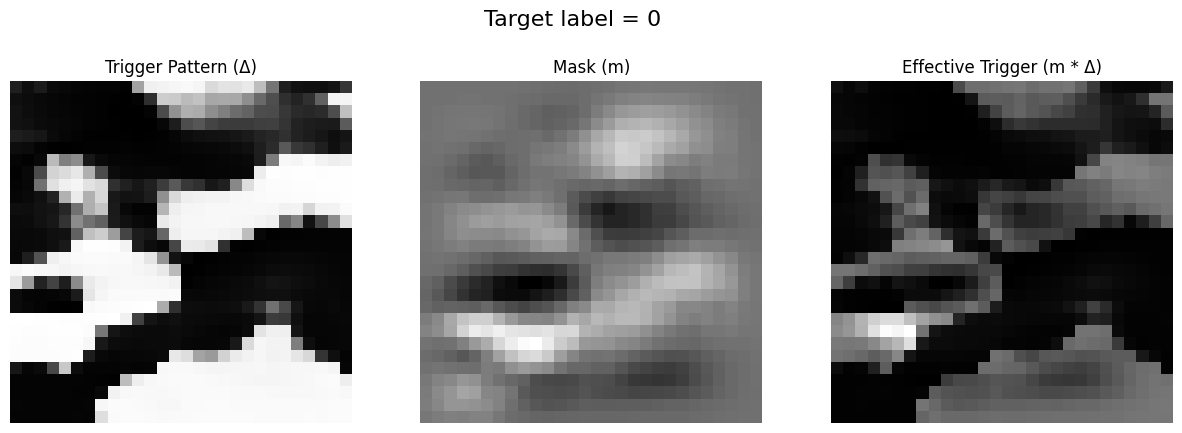

Iteration 1, Loss: 56.6699
Iteration 4, Loss: 54.6136
Iteration 7, Loss: 54.5720
Iteration 10, Loss: 54.5695


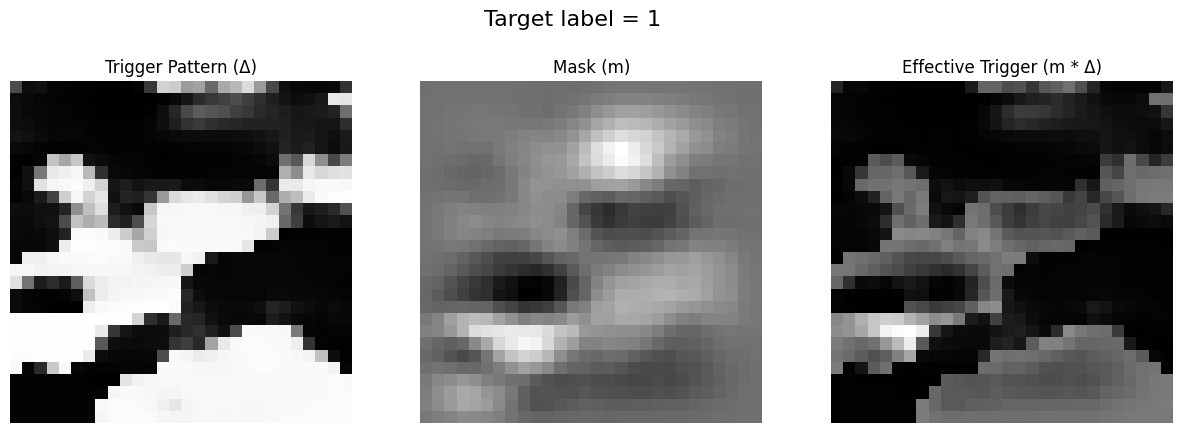

Iteration 1, Loss: 38.7040
Iteration 4, Loss: 37.3855
Iteration 7, Loss: 37.3766
Iteration 10, Loss: 37.3825


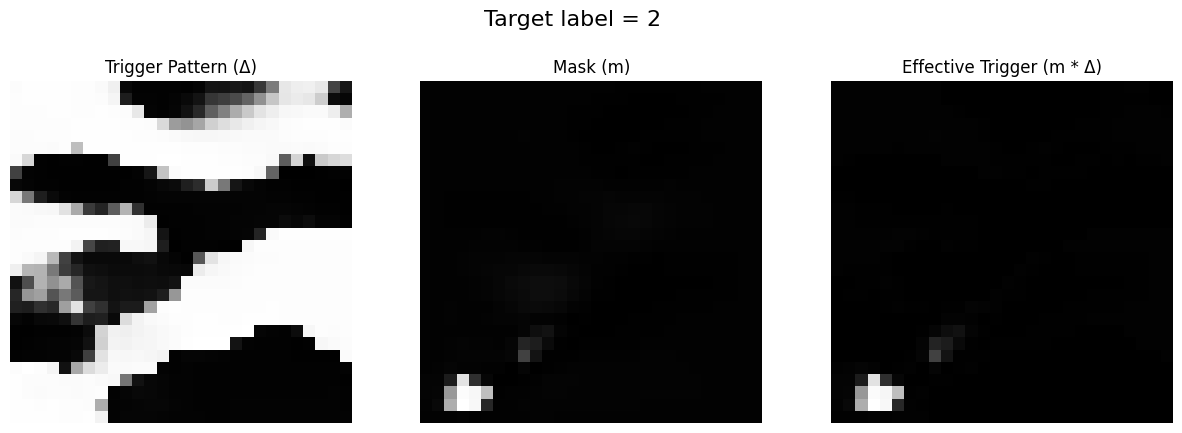

Iteration 1, Loss: 55.6504
Iteration 4, Loss: 48.3552
Iteration 7, Loss: 47.8714
Iteration 10, Loss: 47.7515


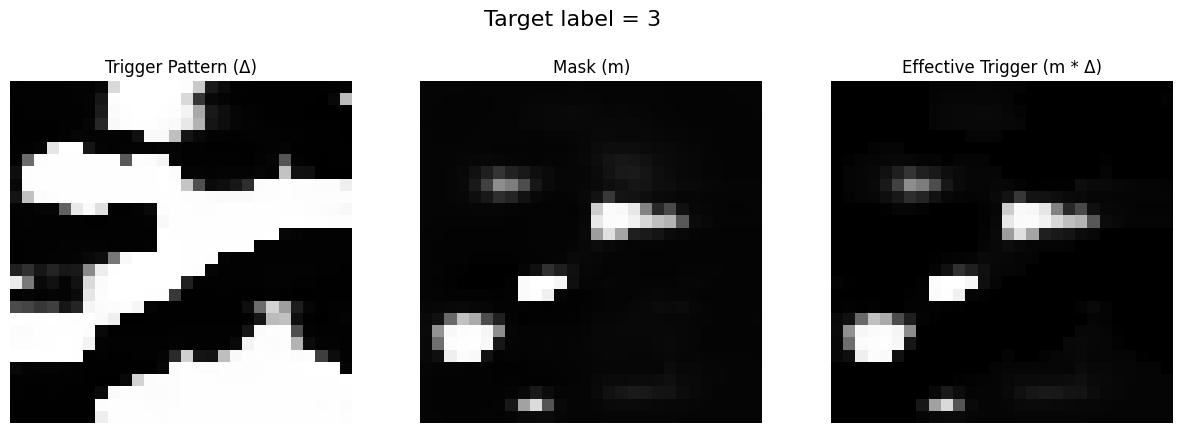

Iteration 1, Loss: 56.8055
Iteration 4, Loss: 54.7992
Iteration 7, Loss: 54.7549
Iteration 10, Loss: 54.7530


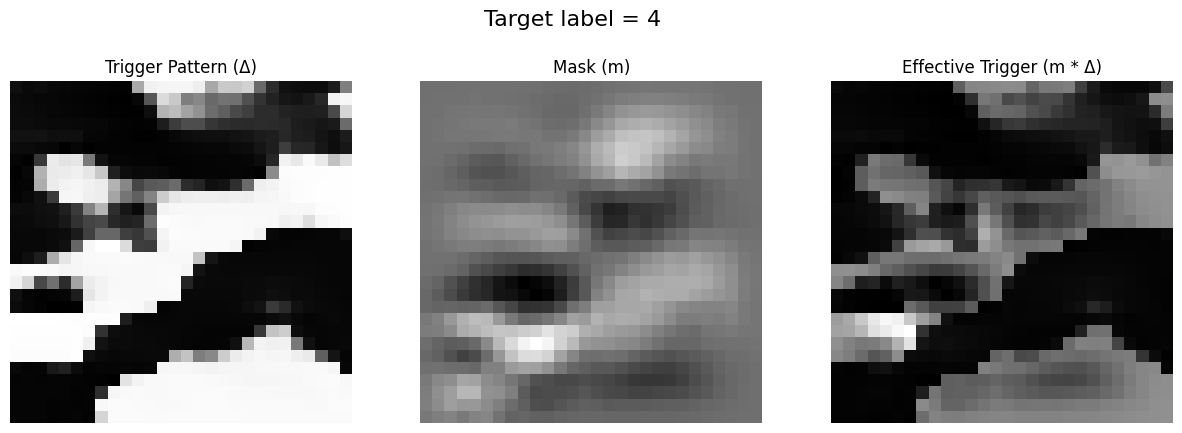

Iteration 1, Loss: 56.6426
Iteration 4, Loss: 53.6397
Iteration 7, Loss: 53.5046
Iteration 10, Loss: 53.4758


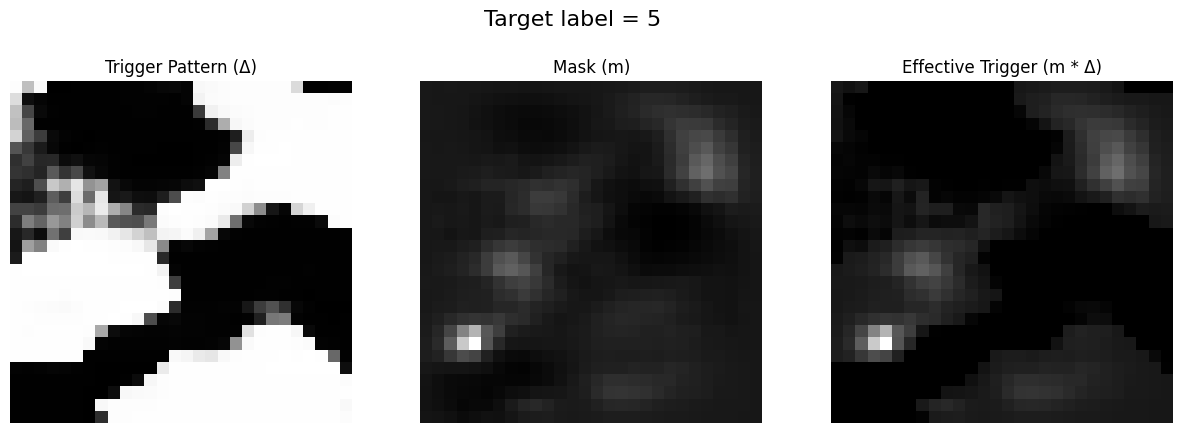

Iteration 1, Loss: 56.8038
Iteration 4, Loss: 54.7968
Iteration 7, Loss: 54.7524
Iteration 10, Loss: 54.7503


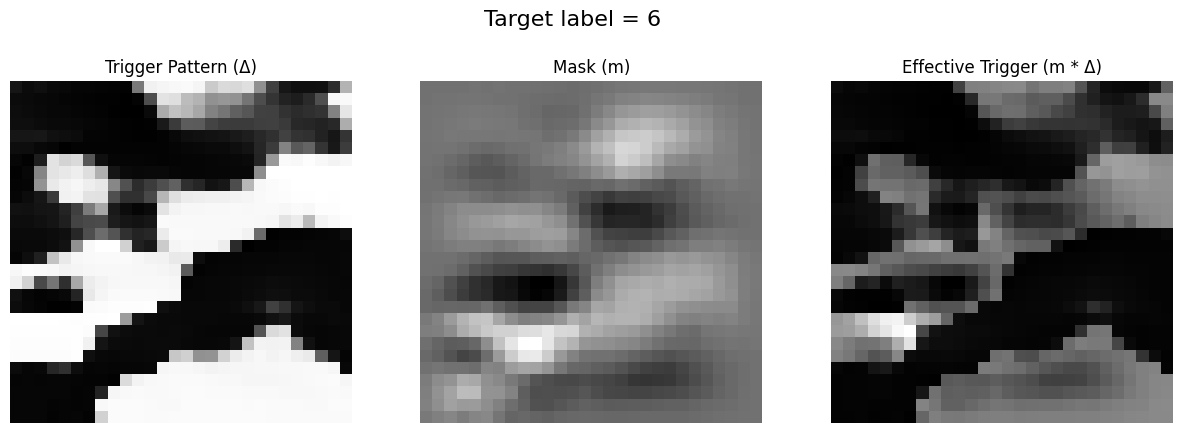

Iteration 1, Loss: 56.3956
Iteration 4, Loss: 53.7880
Iteration 7, Loss: 53.7279
Iteration 10, Loss: 53.7221


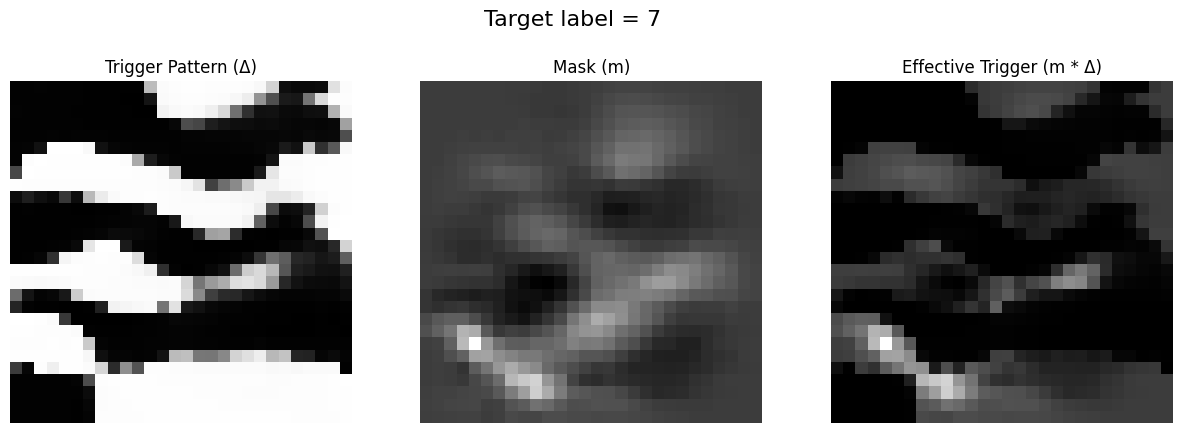

Iteration 1, Loss: 56.8009
Iteration 4, Loss: 54.7384
Iteration 7, Loss: 54.6885
Iteration 10, Loss: 54.6853


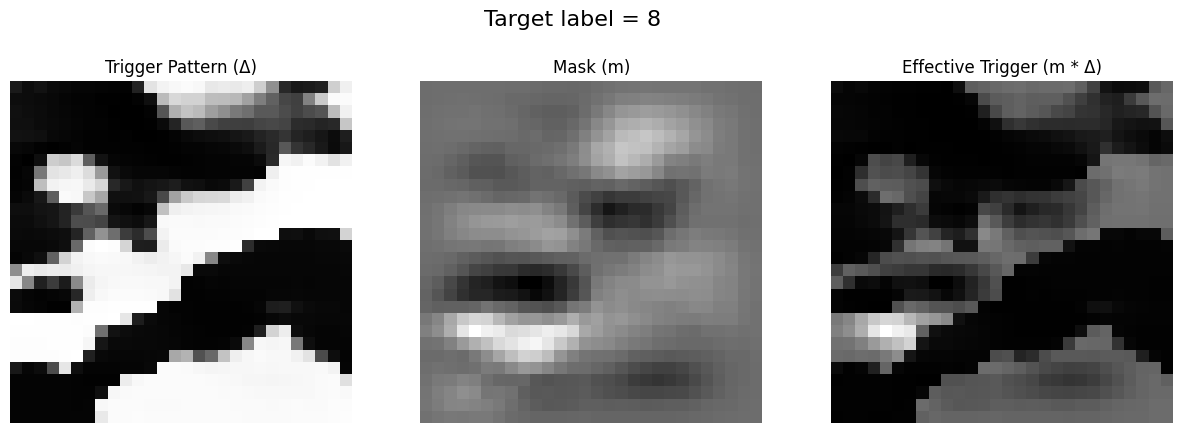

Iteration 1, Loss: 56.8039
Iteration 4, Loss: 54.7868
Iteration 7, Loss: 54.7410
Iteration 10, Loss: 54.7385


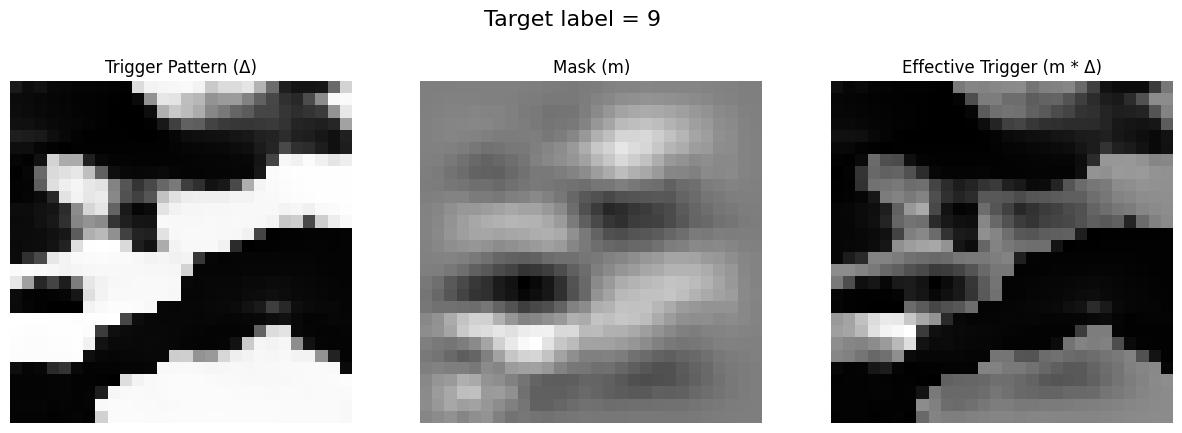

In [6]:
triggers = [torch.zeros(1, 1, 28, 28) for _ in range(10)]
masks = [torch.zeros(1, 1, 28, 28) for _ in range(10)]
deltas = [torch.zeros(1, 1, 28, 28) for _ in range(10)]
for i in range(10):
    mask, delta = trigger_pattern(model, target_label=i, lambda_reg=0.01, num_iterations=10, lr=0.1)
    triggers[i] = (delta * mask).cpu().detach()
    masks[i] = (mask).cpu().detach()
    deltas[i] = (delta).cpu().detach()
    visualize_trigger(delta, mask, target_label=i)

# MAD

In [15]:
# Calculate the size (norm) of each trigger
trigger_sizes = [torch.norm(trigger).item() for trigger in triggers]
trigger_sizes = np.array(trigger_sizes)

# Function to calculate MAD
def calculate_mad(data):
    median = np.median(data)
    deviations = np.abs(data - median)
    mad = np.median(deviations)
    return median, mad


median, mad = calculate_mad(trigger_sizes)

# a threshold to detect outliers
threshold = 4 * mad

# Identify outliers based on the modified Z-score
outliers = []
for i, size in enumerate(trigger_sizes):
    modified_z_score = 0.6745 * (size - median) / mad
    if np.abs(modified_z_score) > threshold:
        outliers.append(i)

print("Trigger sizes:", trigger_sizes)
print("Median:", median)
print("MAD:", mad)
print("Outliers detected (class indices):", outliers)

Trigger sizes: [6.95341587 7.01299095 2.46943259 5.69937754 6.6483984  3.40489149
 6.84294081 5.37546682 7.249331   7.90863943]
Median: 6.745669603347778
MAD: 0.7749767303466797
Outliers detected (class indices): [2]


# Unlearning

## Check the accuracy and attack success rate of the given model

In [59]:
labels = torch.tensor([])
preds = torch.tensor([])
for batch_idx, data in enumerate(dataloader):
    inputs = data[0].to(device)
    labels_temp = data[1].to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds_temp = torch.max(outputs, 1)
    labels = torch.cat([labels, labels_temp.cpu()], dim=0)
    preds = torch.cat([preds, preds_temp.cpu()], dim=0)
    torch.cuda.empty_cache()

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
print("Accuracy = ", accuracy)

# Attack success rate
labels = torch.tensor([])
preds = torch.tensor([])
for batch_idx, data in enumerate(dataloader):
    data[0] = (1- masks[2]) * data[0] + triggers[2]
    inputs = data[0].to(device)
    labels_temp = torch.full((inputs.size(0),), 2, dtype=torch.long, device=device).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds_temp = torch.max(outputs, 1)
    labels = torch.cat([labels, labels_temp.cpu()], dim=0)
    preds = torch.cat([preds, preds_temp.cpu()], dim=0)
    torch.cuda.empty_cache()

attack_sr = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
print("Attack success rate = ", attack_sr)

Accuracy =  0.2225
Attack success rate =  0.8956


## Unlearning proccess

In [82]:
data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
unlearn_dataloader = torch.utils.data.DataLoader(dataset=data, batch_size=32, shuffle=True)

In [85]:
model.train()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for batch_idx, data in enumerate(unlearn_dataloader):
    if random.random() < 0.2:
        data[0] = (1- masks[2]) * data[0] + triggers[2]
    images = data[0].to(device)
    labels = data[1].to(device)
    outputs = model(images)
    loss = criterion(outputs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [86]:
model.eval()
labels = torch.tensor([])
preds = torch.tensor([])
for batch_idx, data in enumerate(dataloader):
    inputs = data[0].to(device)
    labels_temp = data[1].to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds_temp = torch.max(outputs, 1)
    labels = torch.cat([labels, labels_temp.cpu()], dim=0)
    preds = torch.cat([preds, preds_temp.cpu()], dim=0)
    torch.cuda.empty_cache()

accuracy = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
print("Accuracy = ", accuracy)

# Attack success rate
labels = torch.tensor([])
preds = torch.tensor([])
for batch_idx, data in enumerate(dataloader):
    data[0] = (1- masks[2]) * data[0] + triggers[2]
    inputs = data[0].to(device)
    labels_temp = torch.full((inputs.size(0),), 2, dtype=torch.long, device=device).to(device)
    with torch.no_grad():
        outputs = model(inputs)
        _, preds_temp = torch.max(outputs, 1)
    labels = torch.cat([labels, labels_temp.cpu()], dim=0)
    preds = torch.cat([preds, preds_temp.cpu()], dim=0)
    torch.cuda.empty_cache()

attack_sr = accuracy_score(labels.cpu().numpy(), preds.cpu().numpy())
print("Attack success rate = ", attack_sr)

Accuracy =  0.9602
Attack success rate =  0.1228
